***Import libraries***

In [1]:
import pandas as pd
import numpy as np

from math import sqrt
import math
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Flatten, Input
import tensorflow as tf

from tensorflow.python.keras.preprocessing.sequence import TimeseriesGenerator

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

import warnings
warnings.filterwarnings('ignore')

import sklearn

Using TensorFlow backend.


***Load data***

In [2]:

#********Load data**************************
    
data_raw = []
for week in range(1, 6):
    week_data = pd.read_csv('../Paper1/pellosystemout{}.csv'.format(week)).values
    data_raw.append(week_data)
    
data= np.array(data_raw)
dataset= np.concatenate(data)


In [3]:
#******************Z score outlier detection ****************

def remove_outliers(data, threshold=5):
    mean= data.mean()
    std= data.std()
    idx= np.abs((data-mean)/std) <= threshold
    return data[idx].reshape(-1, 1)

In [4]:
# *****************split into train and test sets********************

dataset= np.array(dataset)
dataset = dataset.astype('float32')

print('dataset with outlier', dataset.shape)
dataset= dataset.astype('float32')
dataset= remove_outliers(dataset)
print('dataset after removing outlier', dataset.shape)

dataset with outlier (15453, 1)
dataset after removing outlier (15428, 1)


In [5]:
dataset= pd.DataFrame(dataset)
dataset.columns= ['Traffic']
dataset.head()

,Traffic
0,2460.0
1,5270.0
2,2469.0
3,2479.0
4,2270.0


***Data preprocessing***

In [6]:
#checking for missing values
dataset.isnull().values.any()

False

In [7]:
#Check for missing values
print("total number of rows : {0}".format(len(dataset)))
print("number of rows missing traffic: {0}".format(len(dataset.loc[dataset['Traffic'] == 0])))
print(dataset.head())

#Fill missing values
dataset = dataset.replace(0, np.nan) 
dataset.interpolate(method= 'linear', inplace=True)

#Check how many other missing(zero) values
print("total number of rows : {0}".format(len(dataset)))
print("number of rows missing traffic: {0}".format(len(dataset.loc[dataset['Traffic'] == 0])))
print(dataset.head())

total number of rows : 15428
number of rows missing traffic: 0
   Traffic
0   2460.0
1   5270.0
2   2469.0
3   2479.0
4   2270.0
total number of rows : 15428
number of rows missing traffic: 0
   Traffic
0   2460.0
1   5270.0
2   2469.0
3   2479.0
4   2270.0


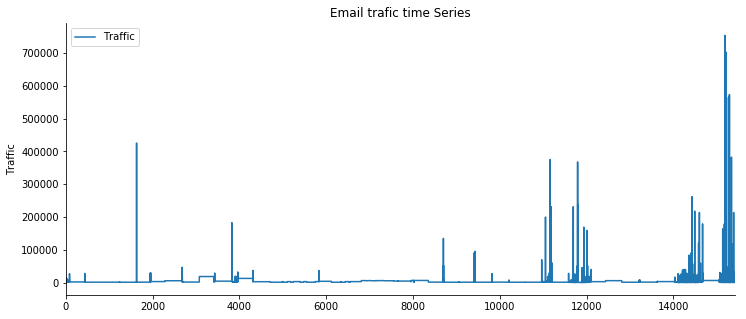

In [8]:
#plt.plot(dataset, label='Traffic')
dataset.plot(figsize=(12,5))
plt.ylabel('Traffic')
plt.title('Email trafic time Series')
sns.despine(top=True)
plt.show();

In [9]:
#dataset= dataset.astype('float64')

In [10]:
# split into train and test dataset

train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size], dataset[train_size:len(dataset)]
print(train.shape, test.shape)

(12342, 1) (3086, 1)


In [11]:
#Normalise the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['Traffic']])

train['Traffic'] = scaler.transform(train[['Traffic']])
test['Traffic'] = scaler.transform(test[['Traffic']])

***Convert to a lagged time series data***

In [12]:

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [13]:

TIME_STEPS = 3

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train[['Traffic']], train, TIME_STEPS)
X_test, y_test = create_dataset(test[['Traffic']], test, TIME_STEPS)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(12339, 3, 1) (12339, 1)
(3083, 3, 1) (3083, 1)


***Create a batch generator to feed the data to the model in batches***

In [14]:
#******************* Batch generator****************************
def batch_generator(X, Y, batch_size):
    """
    Generator function for creating random batches of training-data.
    """
    while True:
        num_records = X.shape[0]
        timesteps = X.shape[1]
        num_batches = num_records // batch_size
        for idx in range(num_batches):
            x = X[idx*batch_size:(idx+1)*batch_size, :]
            y = Y[idx*batch_size:(idx+1)*batch_size, :]
            yield (x, y)

In [15]:
#***********We then create the batch generator***********************
batch_size=8
generator = batch_generator(X_train, X_train, batch_size)
validation_data = batch_generator(X_test, X_test, batch_size)

x_batch, y_batch = next(generator)

print(x_batch.shape)
print(y_batch.shape)

(8, 3, 1)
(8, 3, 1)


***Model***

In [16]:
model = tf.keras.Sequential()

# Encoder
model.add(tf.keras.layers.LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]),
                               return_sequences=True))
#model.add(tf.keras.layers.LSTM(128, return_sequences=True))
model.add(tf.keras.layers.LSTM(128))
model.add(tf.keras.layers.RepeatVector(n=X_train.shape[1]))
    
# Decoder
model.add(tf.keras.layers.LSTM(128,  return_sequences=True))
model.add(tf.keras.layers.LSTM(128, return_sequences=True))
model.add(tf.keras.layers.TimeDistributed(Dense(units=X_train.shape[2])))

model.compile(loss='mae', optimizer='adam')

In [17]:
#***Train the model***
history= model.fit_generator(generator=generator,
                    epochs=500,
                    steps_per_epoch=5, validation_data=validation_data, validation_steps=8, 
                             shuffle=False, verbose=1)

Epoch 1/500
5/5 [==============================] - 3s 628ms/step - loss: 0.1367 - val_loss: 0.0371
Epoch 2/500
5/5 [==============================] - 0s 32ms/step - loss: 0.2054 - val_loss: 0.2856
Epoch 3/500
5/5 [==============================] - 0s 36ms/step - loss: 0.0584 - val_loss: 0.2866
Epoch 4/500
5/5 [==============================] - 0s 31ms/step - loss: 0.0484 - val_loss: 0.1379
Epoch 5/500
5/5 [==============================] - 0s 35ms/step - loss: 0.0403 - val_loss: 0.0823
Epoch 6/500
5/5 [==============================] - 0s 31ms/step - loss: 0.0326 - val_loss: 0.0896
Epoch 7/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0257 - val_loss: 0.0623
Epoch 8/500
5/5 [==============================] - 0s 30ms/step - loss: 0.0172 - val_loss: 0.0630
Epoch 9/500
5/5 [==============================] - 0s 32ms/step - loss: 0.0114 - val_loss: 0.0517
Epoch 10/500
5/5 [==============================] - 0s 30ms/step - loss: 0.0067 - val_loss: 0.0885
Epoch 11/500
5/5 [

***Plot the model training loss***

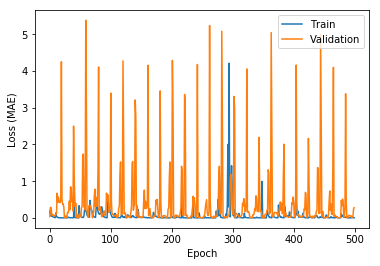

In [18]:
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.ylabel('Loss (MAE)')
plt.xlabel('Epoch')
plt.legend()
plt.show()

***Reconstruction error scores***

In [19]:
print(X_test.shape)
print(y_test.shape)

(3083, 3, 1)
(3083, 1)


In [20]:
# model predict
test_x_predictions = model.predict(X_test)

In [21]:
# Reshape from 3D to 2D
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1]))
test_x_predictions = test_x_predictions.reshape((test_x_predictions.shape[0], test_x_predictions.shape[1]))

# Reconstruction Mean absolute Error score
def mae(X_test, test_x_predictions):
    return sklearn.metrics.mean_absolute_error(X_test, test_x_predictions)

MAE= mae(X_test, test_x_predictions)
print('Reconstruction_error MAE', MAE)

# Reconstruction Mean square Error score
def mse(X_test, test_x_predictions):
    return sklearn.metrics.mean_squared_error(X_test, test_x_predictions)

MSE= mse(X_test, test_x_predictions)
print('Reconstruction_error MSE',MSE)

# Reconstruction Root mean square error score
def rmse(X_test, test_x_predictions):
    return math.sqrt(sklearn.metrics.mean_squared_error(X_test, test_x_predictions)) 

RMSE= rmse(X_test, test_x_predictions)
print('Reconstruction_error RMSE',RMSE)


Reconstruction_error MAE 0.4159252193742828
Reconstruction_error MSE 11.767579794119937
Reconstruction_error RMSE 3.4303906182998953


In [22]:
# *************************invert predictions**************************

testPredict_inv = scaler.inverse_transform(test_x_predictions)
test_X_inv = scaler.inverse_transform(X_test)

#***MAE***
Inverse_MAE= mae(test_X_inv, testPredict_inv)
print('Reconstruction_error inverse MAE', Inverse_MAE)

#***MSE***
Inverse_MSE= mse(test_X_inv, testPredict_inv)
print('Reconstruction_error inverse MSE',Inverse_MSE)

# ********************RMSE*************************
Inverse_RMSE= rmse(test_X_inv, testPredict_inv)
print('Reconstruction_error inverse RMSE',Inverse_RMSE)

Reconstruction_error inverse MAE 4714.339520393674
Reconstruction_error inverse MSE 1511813961.41607
Reconstruction_error inverse RMSE 38882.05191879757


In [23]:
# *************************invert predictions**************************
trainPredict = model.predict(X_train)

trainPredict_inv = scaler.inverse_transform(trainPredict)
train_X_inv = scaler.inverse_transform(X_train)

testPredict_inv = scaler.inverse_transform(test_x_predictions)
test_X_inv = scaler.inverse_transform(X_test)

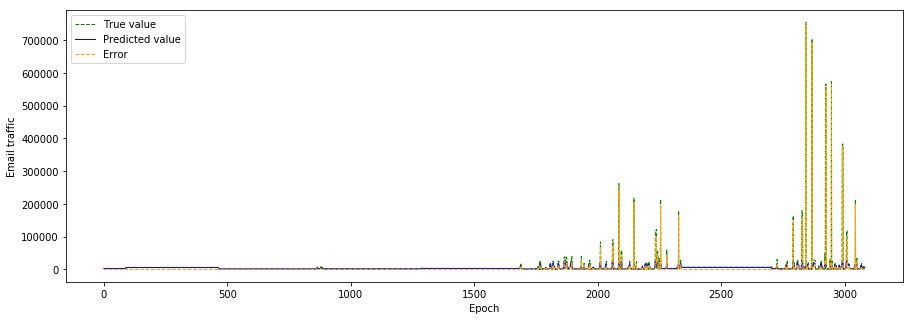

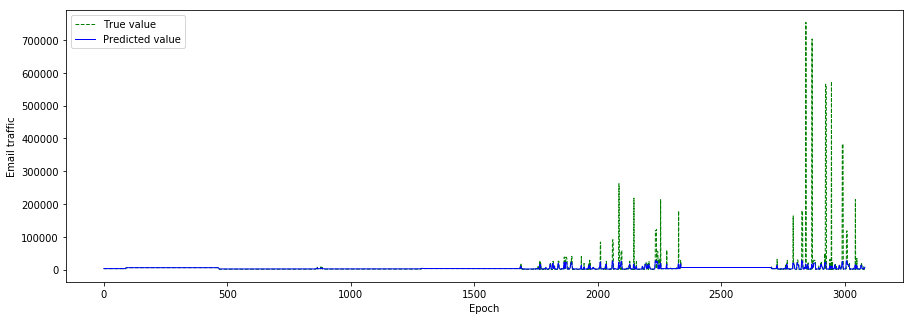

In [24]:
#********************* Actual value, Predicted value and Prediction Error ***************

plt.figure(figsize = (15, 5))
plt.xlabel("Epoch")
plt.ylabel("Email traffic")
plt.plot(test_X_inv[:,0], label="True value", linewidth=1,linestyle="--",color= 'green')
plt.plot(testPredict_inv[:,0], label="Predicted value", linewidth=1,color='blue')

error = abs(test_X_inv[:,0] - testPredict_inv[:,0])
plt.plot(error, label='Error',color= 'orange', linewidth=1, linestyle="--")
plt.legend()
plt.show()

#******************************* True value vs Prediction **********************/

plt.figure(figsize = (15, 5))
plt.xlabel("Epoch")
plt.ylabel("Email traffic")
plt.plot (test_X_inv[:,0], label="True value", linewidth=1,color= 'green', linestyle="--")
plt.plot(testPredict_inv[:,0], label="Predicted value", linewidth=1,color='blue')
plt.legend()
plt.show()

***Loss distribution***

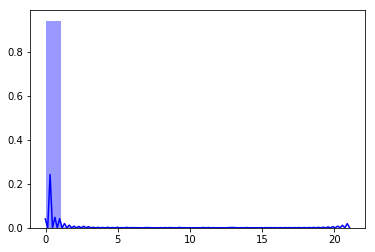

In [25]:
# plot the loss distribution of the training set

X_pred= model.predict(X_train)
Loss_mae = np.mean(np.abs(X_pred-X_train), axis=1)
#plt.figure(figsize =(16,9), dpi=80)
#plt.title('Loss distribution', fontsize=16)
sns.distplot(Loss_mae, bins=20, kde=True, color='blue');
#plt.xlim([0.0,.5])

(0.0, 5)

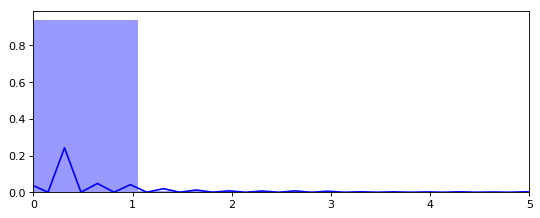

In [26]:
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

#lets look at the error
plt.figure(figsize= (8, 3), dpi=80)
sns.distplot(train_mae_loss, bins=20, kde=True, color='blue');
plt.xlim([0.0, 5])

***Threshold for flagging an anomaly***

In [27]:
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
test_x_predictions = model.predict(X_test)
mae = np.mean(np.power(X_test - test_x_predictions, 2), axis=1)
error_df = pd.DataFrame(data=np.concatenate((mae, y_test), axis=1), columns=["Reconstruction_error", "True_class"])
error_df.describe()

,Reconstruction_error,True_class
count,3.083000e+03,3083.000000
mean,1.176758e+01,0.319729
std,1.372611e+02,3.528767
min,6.640643e-07,-0.306221
25%,3.612211e-04,-0.248256
50%,4.064968e-03,-0.110448
75%,8.185373e-03,0.169668
max,2.852703e+03,66.205526


In [28]:
THRESHOLD = 0.001

error_df = pd.DataFrame(index=test[TIME_STEPS:].index)
error_df['loss'] = mae
error_df['threshold'] = THRESHOLD
error_df['True_class']= y_test
error_df['Reconstruction_error']= mae

error_df['anomaly'] = error_df.loss > error_df.threshold
error_df['normal'] = error_df.True_class <= error_df.threshold

#error_df["anomaly"] = (error_df["Reconstruction_error"]>THRESHOLD)
#error_df["normal"] = (error_df["True_class"]<=THRESHOLD)



predicted_test_anomalies = [1 if e > THRESHOLD else 0 for e in error_df.Reconstruction_error.values]
error_df['anomaly_predicted']= predicted_test_anomalies

print(classification_report(error_df.normal, predicted_test_anomalies))

#error_df["anomaly"] = (error_df.Reconstruction_error > THRESHOLD).astype(int)
#error_df["normal"] = (error_df.True_class <= THRESHOLD).astype(int)

error_df['Traffic'] = test[TIME_STEPS:]

              precision    recall  f1-score   support

       False       0.57      0.76      0.65      1009
        True       0.86      0.72      0.79      2074

   micro avg       0.74      0.74      0.74      3083
   macro avg       0.72      0.74      0.72      3083
weighted avg       0.77      0.74      0.74      3083



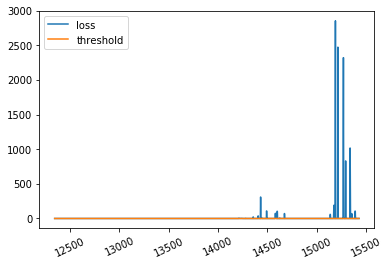

In [29]:
plt.plot(error_df.index, error_df.loss, label='loss')
plt.plot(error_df.index, error_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();

In [30]:
anomalies = error_df[error_df.anomaly == True]
anomalies.head()

,loss,threshold,True_class,Reconstruction_error,anomaly,normal,anomaly_predicted,Traffic
12433,0.016603,0.001,0.169668,0.016603,True,False,1,0.169668
12434,0.017230,0.001,0.169668,0.017230,True,False,1,0.169668
12810,0.040895,0.001,-0.248256,0.040895,True,True,1,-0.248256
12811,0.042412,0.001,-0.248256,0.042412,True,True,1,-0.248256
12812,0.005511,0.001,-0.248256,0.005511,True,True,1,-0.248256


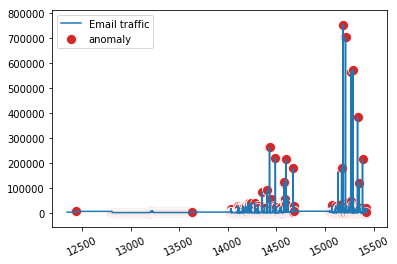

In [31]:

plt.plot(
  test[TIME_STEPS:].index, 
  scaler.inverse_transform(test[TIME_STEPS:].Traffic), 
  label='Email traffic'
);

sns.scatterplot(
  anomalies.index,
  scaler.inverse_transform(anomalies.Traffic),
  color=sns.color_palette()[3],
  s=100,
  label='anomaly'
)

plt.xticks(rotation=25)
plt.legend();

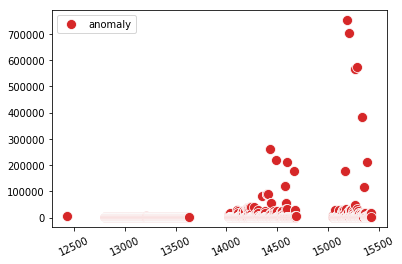

In [32]:
sns.scatterplot(
  anomalies.index,
  scaler.inverse_transform(anomalies.Traffic),
  color=sns.color_palette()[3],
  s=100,
  label='anomaly'
)
plt.xticks(rotation=25)
plt.legend()

In [33]:
print(classification_report(error_df["normal"], error_df["anomaly"]))

              precision    recall  f1-score   support

       False       0.57      0.76      0.65      1009
        True       0.86      0.72      0.79      2074

   micro avg       0.74      0.74      0.74      3083
   macro avg       0.72      0.74      0.72      3083
weighted avg       0.77      0.74      0.74      3083



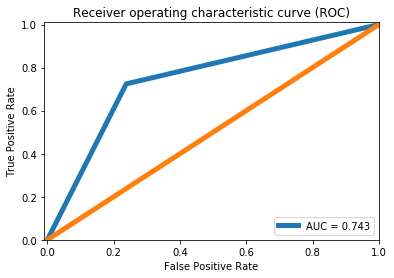

In [34]:
# ROC curve
false_pos_rate, true_pos_rate, THRESHOLD = roc_curve(error_df["normal"], error_df["anomaly"])
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

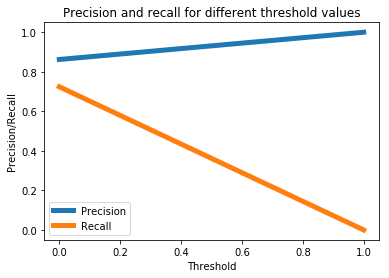

In [35]:
#Precision recall matrix
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df["normal"], error_df["anomaly"])
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

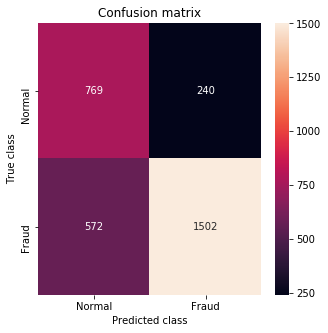

In [36]:
#Confusion matrix
LABELS = ["Normal", "Fraud"]
conf_matrix = confusion_matrix(error_df["normal"], error_df["anomaly"])

plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS,annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()